# Trends-based recommendation
In this notebook we will classify the tweets into trends and these trends will help us decide which hashtags to recommend 

In [1]:
import sys

sys.path.append(sys.path[0] + './../')

In [2]:
from NLP.files_reader import *
import tensorflow as tf
import nltk

## Get the data

In [3]:
tweets_and_trends = []
tweets = []
trends = []

files_prefix = './../'

tweets_and_trends += (FilesReader.read_file(files_prefix + new_US_file))
tweets_and_trends += (FilesReader.read_file(files_prefix + new_UK_file))
tweets_and_trends += (FilesReader.read_file(files_prefix + new_AUS_file))
tweets_and_trends += (FilesReader.read_file(files_prefix + new_CAN_file))
tweets_and_trends += (FilesReader.read_file(files_prefix + new_IR_file))

random.shuffle(tweets_and_trends)

tweets, trends = FilesReader.split_tweets_and_trends(tweets_and_trends)
print(f"We have {len(tweets)} tweets.")


We have 132165 tweets.


## Stemming and lemmatization

In [ ]:
from NLP.lemmatizer_and_stemmer import LemmatizerAndStemmer

print(f"before: {tweets[:3]}")
for i, tweet in enumerate(tweets):
    processed_tweet = LemmatizerAndStemmer.stem_and_lemmatize_tweet(tweet)
    tweets[i] = processed_tweet
    

print(f"after: {tweets[:3]}")

## Tokenize the text

In [ ]:
from keras.preprocessing.text import Tokenizer

tweets_tokenizer = Tokenizer(oov_token="<OOV>")
tweets_tokenizer.fit_on_texts(tweets)
tweets_word_index = tweets_tokenizer.word_index
tweets_index_word = tweets_tokenizer.index_word

print(f"We have {len(tweets_word_index)} different words")
print(tweets_word_index)

## Create the padded sequences

In [6]:
from keras.utils import pad_sequences
sequence_length = 15

tweets_sequences = tweets_tokenizer.texts_to_sequences(tweets)
tweets_sequences_padded = pad_sequences(tweets_sequences, padding="post", maxlen=sequence_length)

## Map the trends to numbers

In [ ]:
trends_map = {}

counter = 0

for trend in trends:
    if not (trend in trends_map):
        trends_map[trend] = counter
        counter += 1

no_of_trends = len(trends_map)
inv_trends_map = {v: k for k, v in trends_map.items()}
print(f"We have {no_of_trends} different trends")
print(trends_map)

## Create the trends sequences

In [ ]:
trends_sequences = [trends_map[trend] for trend in trends]
print(trends_sequences)

## Encode the trends

In [9]:
from keras.utils import to_categorical
import tensorflow as tf

encoded_trends = to_categorical(trends_sequences)
print(encoded_trends.shape)

(132165, 46)


## Prepare the pre-trained embeddings

In [10]:
from NLP.Embeddings.embeddings_matrix import get_embeddings_matrix

embeddings_index_path = "./../NLP/Embeddings/embeddings_index_object.pkl"
embeddings_matrix, hits, misses = get_embeddings_matrix(tweets_word_index, embeddings_index_path)

print(f"Hits: {hits}, Misses: {misses}")

Hits: 27418, Misses: 21288


## Split the data

In [11]:
training_split = 0.8
training_tweets_count = int(0.8 * len(tweets_sequences_padded))

In [12]:
train_data = tweets_sequences_padded[0:training_tweets_count]
train_labels = encoded_trends[0:training_tweets_count]
test_data = tweets_sequences_padded[training_tweets_count:]
test_labels = encoded_trends[training_tweets_count:]

print(f'we have {len(train_data)} tweets for training and {len(test_data)} for testing')

we have 105732 tweets for training and 26433 for testing


## Tune the hyper-parameters

In [ ]:
# import keras_tuner as kt
# import keras
# from keras import initializers
# import tensorflow as tf

# no_of_tweets_words = len(tweets_word_index) + 1
# embedding_dimensions = 300

# def model_builder(hp):
#     model = keras.Sequential()

#     hp_conv_filters = hp.Int('conv_filters', min_value=32, max_value=256, step=16)
#     hp_kernel_size = hp.Int('conv_kernel_size', min_value=2, max_value=5, step=1)
#     hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.6, step=0.1)
#     hp_lstm = hp.Int('lstm_units', min_value=32, max_value=256, step=16)

#     model.add(keras.layers.Embedding(
#         no_of_tweets_words,
#         embedding_dimensions,
#         input_length=sequence_length,
#         embeddings_initializer=initializers.Constant(embeddings_matrix),
#         trainable=True
#     ))
#     model.add(keras.layers.Conv1D(hp_conv_filters, hp_kernel_size, padding='same'))
#     model.add(keras.layers.Dropout(hp_dropout))
#     model.add(keras.layers.Bidirectional(keras.layers.LSTM(hp_lstm)))
#     model.add(keras.layers.Dropout(hp_dropout))
#     model.add(keras.layers.Dense(no_of_trends))

#     # Tune the learning rate for the optimizer
#     # Choose an optimal value from 0.01, 0.001, or 0.0001
#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                   loss=keras.losses.CategoricalCrossentropy(
#                       from_logits=True),
#                   metrics=['accuracy'])

#     return model


In [ ]:
# tuner = kt.Hyperband(model_builder,
#                      objective='val_accuracy',
#                      max_epochs=6,
#                      factor=3,
#                      directory='parameters_tuning',
#                      project_name='trends_classifier')

In [ ]:
# tuner.search(train_data, train_labels, epochs=50, validation_data=(test_data, test_labels))

In [ ]:
# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The hyperparameter search is complete. Here are the optimal configurations:
#     conv_filters: {best_hps.get('conv_filters')}
#     conv_kernel_size: {best_hps.get('conv_kernel_size')}
#     lstm_units: {best_hps.get('lstm_units')}
#     dropout: {best_hps.get('dropout')}
#     learning_rate: {best_hps.get('learning_rate')}
# """)

In [ ]:
# trends_classifier = tuner.hypermodel.build(best_hps)
# history = trends_classifier.fit(train_data, train_labels, epochs=20, validation_data=(test_data, test_labels))

# val_acc_per_epoch = history.history['val_accuracy']
# best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
# print('Best epoch: %d' % (best_epoch,))

In [ ]:
# trends_classifier = tuner.hypermodel.build(best_hps)
# trends_classifier.fit(train_data, train_labels, epochs=best_epoch, validation_data=(test_data, test_labels))

## Build the model
After tuning the hyper-parameters, here are the optimal configurations: <br>
    conv_filters: 224 <br>
    conv_kernel_size: 2<br>
    lstm_units: 144<br>
    dropout: 0.1<br>
    learning_rate: 0.001<br>

In [13]:
#hyperparameters
embedding_dimensions = 300
lstm_units = 144
dropout_value = 0.1
conv_filters = 224
conv_kernel_size = 2

In [14]:
from keras import initializers
import tensorflow as tf

no_of_tweets_words = len(tweets_word_index) + 1

trends_classifier = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        no_of_tweets_words,
        embedding_dimensions,
        input_length=sequence_length,
        embeddings_initializer=initializers.Constant(embeddings_matrix),
        trainable=True
    ),
    tf.keras.layers.Conv1D(conv_filters, conv_kernel_size, activation='relu'),
    tf.keras.layers.AveragePooling1D(),
    tf.keras.layers.Dropout(dropout_value),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, activation='tanh')),
    tf.keras.layers.Dropout(dropout_value),
    tf.keras.layers.Dense(no_of_trends, activation='softmax')
])

trends_classifier.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

trends_classifier.summary()

# trends_classifier = tf.keras.models.load_model("trends_classifier")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 300)           14612100  
                                                                 
 conv1d (Conv1D)             (None, 14, 224)           134624    
                                                                 
 average_pooling1d (AverageP  (None, 7, 224)           0         
 ooling1D)                                                       
                                                                 
 dropout (Dropout)           (None, 7, 224)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 288)              425088    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 288)               0

In [15]:
epochs = 4
history = trends_classifier.fit(train_data, train_labels, epochs=epochs, validation_data=(test_data, test_labels))

Epoch 1/4
3305/3305 [==============================] - 82s 21ms/step - loss: 0.9443 - accuracy: 0.7537 - val_loss: 0.7296 - val_accuracy: 0.8016
Epoch 2/4
3305/3305 [==============================] - 70s 21ms/step - loss: 0.5795 - accuracy: 0.8398 - val_loss: 0.7080 - val_accuracy: 0.8128
Epoch 3/4
3305/3305 [==============================] - 69s 21ms/step - loss: 0.4014 - accuracy: 0.8852 - val_loss: 0.7483 - val_accuracy: 0.8117
Epoch 4/4
3305/3305 [==============================] - 70s 21ms/step - loss: 0.2876 - accuracy: 0.9144 - val_loss: 0.8358 - val_accuracy: 0.8116


## Save the model

In [ ]:
import pickle

trends_classifier.save("../NLP/trends_classifier/trends_classifier_model.h5")
with open('../NLP/trends_classifier/inv_trends_map.pkl', 'wb') as output:
    pickle.dump(inv_trends_map, output)
with open('../NLP/trends_classifier/tweet_tokenizer.pkl', 'wb') as output:
    pickle.dump(tweets_tokenizer, output)


## Confusion matrix

In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix

In [17]:
predictions = trends_classifier.predict(test_data)
predicted_trends = np.argmax(predictions, axis=1)
true_trends = np.argmax(test_labels, axis=1)

confusion_matrix = confusion_matrix(true_trends, predicted_trends)

827/827 [==============================] - 4s 4ms/step


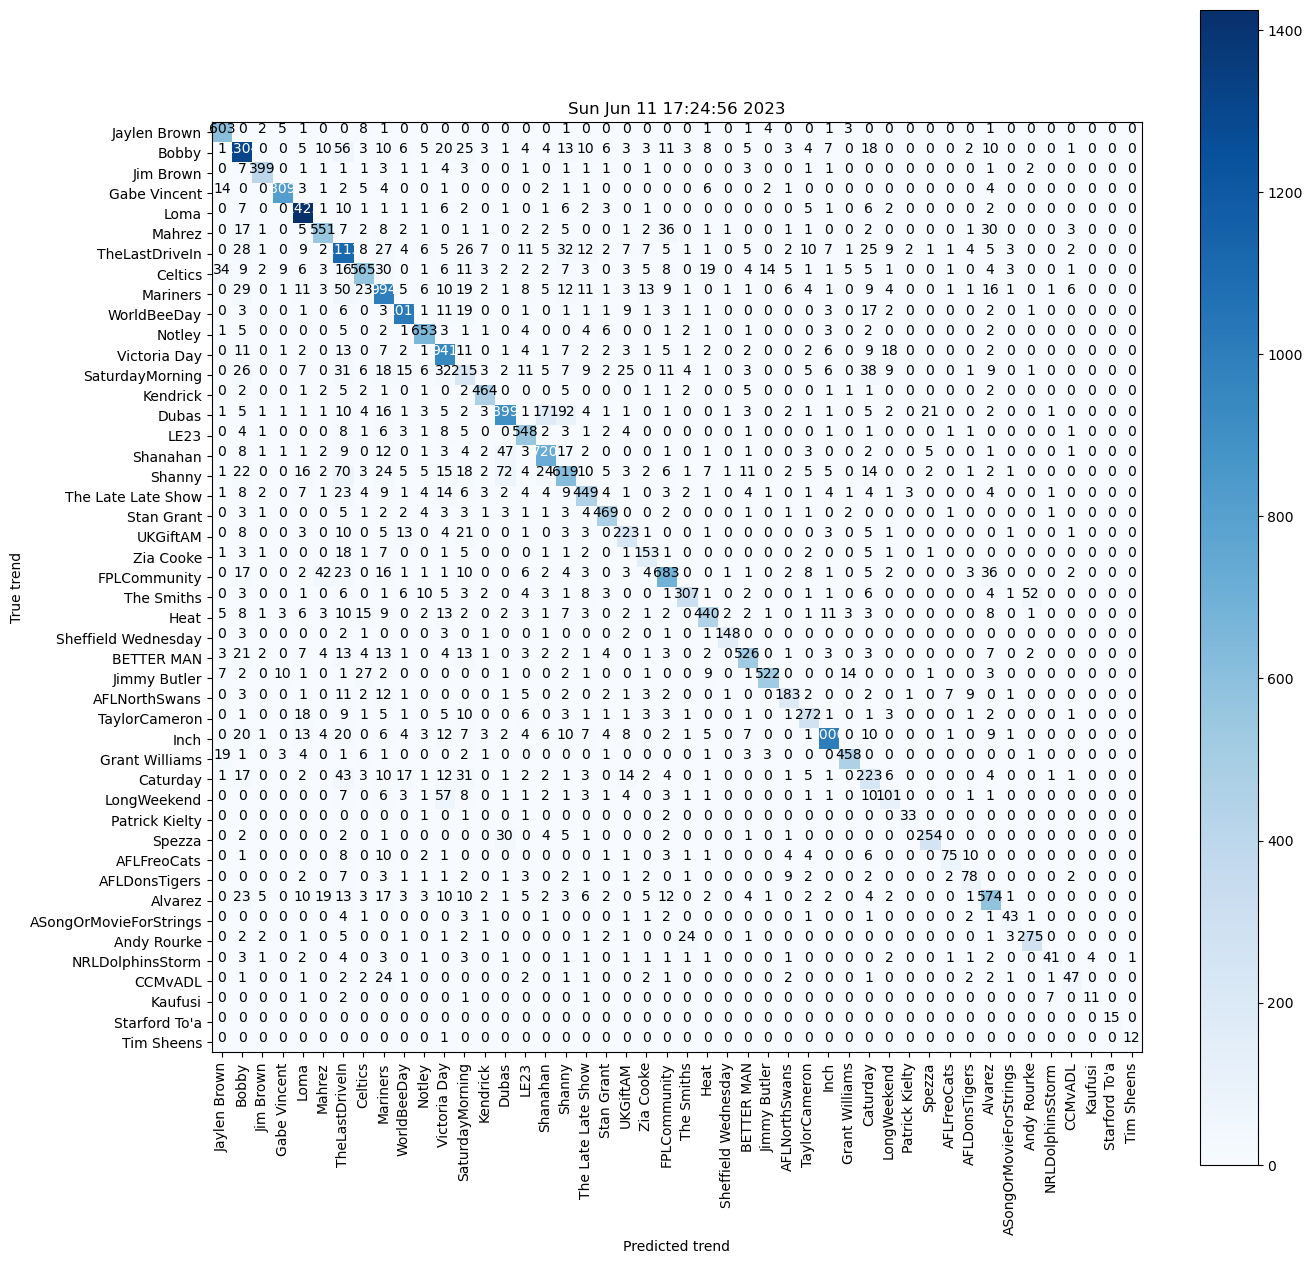

In [18]:
import matplotlib.pyplot as plt
from time import ctime
from sklearn.metrics import classification_report

trends_names = [trend[0] for trend in trends_map.items()]

fig, ax = plt.subplots(figsize=(15, 15))

# Plotting the confusion matrix
im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title(ctime())
plt.colorbar(im, ax=ax)

tick_marks = np.arange(len(trends_names))
plt.xticks(tick_marks, trends_names, rotation=90)
plt.yticks(tick_marks, trends_names)

thresh = confusion_matrix.max() / 2.0
for i, j in np.ndindex(confusion_matrix.shape):
    ax.text(j, i, format(confusion_matrix[i, j], 'd'),
            horizontalalignment="center",
            color="white" if confusion_matrix[i, j] > thresh else "black")

plt.ylabel('True trend')
plt.xlabel('Predicted trend')

plt.savefig('../NLP/Model_reports/plots/' + ctime().replace(' ', '_').replace(':', '_') + '.png', dpi=300)



In [19]:
from sklearn.metrics import classification_report
report = classification_report(true_trends, predicted_trends, target_names=trends_names,  output_dict=True)
print(report)

{'Jaylen Brown': {'precision': 0.8713872832369942, 'recall': 0.9541139240506329, 'f1-score': 0.9108761329305136, 'support': 632}, 'Bobby': {'precision': 0.7965791081246182, 'recall': 0.8337595907928389, 'f1-score': 0.8147453920649796, 'support': 1564}, 'Jim Brown': {'precision': 0.9410377358490566, 'recall': 0.9172413793103448, 'f1-score': 0.9289871944121071, 'support': 435}, 'Gabe Vincent': {'precision': 0.9596678529062871, 'recall': 0.9450934579439252, 'f1-score': 0.9523248969982342, 'support': 856}, 'Loma': {'precision': 0.9036144578313253, 'recall': 0.9595959595959596, 'f1-score': 0.9307642064010451, 'support': 1485}, 'Mahrez': {'precision': 0.8450920245398773, 'recall': 0.8055555555555556, 'f1-score': 0.8248502994011977, 'support': 684}, 'TheLastDriveIn': {'precision': 0.6700782661047562, 'recall': 0.7972779369627507, 'f1-score': 0.7281648675171738, 'support': 1396}, 'Celtics': {'precision': 0.8036984352773826, 'recall': 0.7142857142857143, 'f1-score': 0.7563587684069611, 'support

In [20]:
print(report['weighted avg'])

{'precision': 0.8143004639659557, 'recall': 0.8116369689403398, 'f1-score': 0.8110810551477377, 'support': 26433}


## Model report

In [21]:
import pandas as pd

report_data_frame_dict = {
    'time': [ctime()],
    'accuracy' : [report['accuracy']],
    'precision' : [report['weighted avg']['precision']],
    'recall' : [report['weighted avg']['recall']],
    'f1_score' : [report['weighted avg']['f1-score']],
    'loss' : [history.history['loss'][-1]],
    'number of tweets': [len(tweets)],
    'number of trends': [no_of_trends]
}

report_data_frame = pd.DataFrame(report_data_frame_dict)

report_data_frame.to_csv('../NLP/Model_reports/model_report.csv', mode='a', index=False, header=False)
